In [1]:
import os
import six
import glob
import pickle

import numpy as np
import pandas as pd
from scipy.stats import circvar

import p2pspatial
import pulse2percept.utils as p2pu

from sklearn.base import clone
import sklearn.metrics as sklm

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-04-05 18:02:39,361 [pulse2percept] [INFO] Welcome to pulse2percept


# Load data

In [2]:
def load_data(pickle_files, verbose=True):
    data = []
    for pickle_file in pickle_files:
        if verbose:
            print('- Processing %s' % pickle_file)
        y, y_pred, best_params, specifics = pickle.load(open(pickle_file, 'rb'))
        if isinstance(specifics, list):
            assert np.allclose([s['avg_img'] for s in specifics], True)
            specifics = specifics[0]
        else:
            assert specifics['avg_img']
        if isinstance(y, list):
            y = pd.concat(y)
        if isinstance(y_pred, list):
            y_pred = pd.concat(y_pred)
            
        best_cost = 0
        r2_scores = {}
        for col in y_pred.drop(columns=['electrode', 'image']).columns:
            yt = np.array(y.loc[:, col], dtype=float)
            yp = np.array(y_pred.loc[:, col], dtype=float)
            # Adjusted R squared:
            # https://stackoverflow.com/questions/42033720/python-sklearn-multiple-linear-regression-display-r-squared
            # I think yt.shape[1] is wrong - it should be X.shape[1] so the number of vars to compute df
            # And we don't know this
#             r2_scores['r2_' + col] = 1 - (1-sklm.r2_score(yt, np.nan_to_num(yp)))*(len(yt)-1)/(len(yt)-yt.shape[1]-1)
            if col == 'orientation':
                # circular error
                err = np.abs(yt - np.nan_to_num(yp))
                err = np.where(err > np.pi / 2, np.pi - err, err)
                ss_res = np.sum(err ** 2)
                ss_tot = np.sum((yt - np.mean(yt)) ** 2)
#                 ss_tot = circvar(yt, low=-np.pi / 2, high=np.pi / 2) * len(yt)
                r2_scores['r2_orientation'] = 1 - ss_res / ss_tot
            else:
                r2_scores['r2_' + col] = sklm.r2_score(yt, np.nan_to_num(yp))
            l = 1 - r2_scores['r2_' + col]
            best_cost += 2 if np.isnan(l) else l
        row = {
            'subject': specifics['subject'],
            'model': specifics['modelname'],
            'exetime': specifics['exetime'],
            'adjust_bias': specifics['adjust_bias'],
#             'best_params': best_params,
            'best_cost': best_cost,# if 'best_score' not in specifics else specifics['best_score'],
            'n_samples': len(yt),
            'filepath': os.path.dirname(pickle_file),
            'filename': os.path.basename(pickle_file)
        }
#         row.update(best_params)
        row.update(r2_scores)
        data.append(row)
    return pd.DataFrame(data)

In [3]:
results_dir = '../../results/shape2fit/'
pickle_files = np.sort(glob.glob(os.path.join(results_dir, '*.pickle')))
print('Found', len(pickle_files), 'files')

Found 147 files


In [4]:
subjects = ['12-005', '51-009', '52-001', 'TB']
models = ['A', 'C', 'D2', 'E2', 'F2']
assert_params = {
    'amplitude': 2.0,
}
rootfolder = os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape')

In [5]:
data = load_data(pickle_files, verbose=False)
data

,adjust_bias,best_cost,exetime,filename,filepath,model,n_samples,r2_area,r2_compactness,r2_eccentricity,r2_orientation,subject
0,False,12.072992,70.311703,12-005_A_shape2fit-swarm_2018-04-04_07-55-34.p...,../../results/shape2fit,A,19,-6.490229,-0.890540,-0.218503,-0.473721,12-005
1,False,12.205149,217.199933,12-005_A_shape2fit-swarm_2018-04-04_07-55-58.p...,../../results/shape2fit,A,19,-6.558594,-1.158437,-0.112213,-0.375905,12-005
2,False,11.798353,99.404655,12-005_A_shape2fit-swarm_2018-04-04_07-56-09.p...,../../results/shape2fit,A,19,-6.540352,-0.909682,0.091071,-0.439390,12-005
3,False,12.037832,67.975284,12-005_A_shape2fit-swarm_2018-04-04_07-56-23.p...,../../results/shape2fit,A,19,-6.468481,-0.854389,-0.310880,-0.404082,12-005
4,False,12.289184,53.513240,12-005_A_shape2fit-swarm_2018-04-04_07-56-39.p...,../../results/shape2fit,A,19,-6.534861,-0.894862,-0.439228,-0.420232,12-005
5,True,9.423600,106.139188,12-005_A_shape2fit-swarm_2018-04-05_02-37-18.p...,../../results/shape2fit,A,18,-3.652469,-1.588681,-0.024251,-0.158199,12-005
6,True,9.734215,83.793379,12-005_A_shape2fit-swarm_2018-04-05_06-28-41.p...,../../results/shape2fit,A,18,-3.651506,-1.577167,-0.347342,-0.158200,12-005
7,True,9.706480,78.480409,12-005_A_shape2fit-swarm_2018-04-05_07-37-38.p...,../../results/shape2fit,A,18,-3.646915,-1.540167,-0.418970,-0.100428,12-005
8,True,9.706480,98.359611,12-005_A_shape2fit-swarm_2018-04-05_12-12-17.p...,../../results/shape2fit,A,18,-3.646915,-1.540167,-0.418970,-0.100428,12-005
9,True,9.774057,88.964688,12-005_A_shape2fit-swarm_2018-04-05_16-01-38.p...,../../results/shape2fit,A,18,-3.662844,-1.844419,-0.178414,-0.088380,12-005


In [6]:
data.n_samples.unique()

array([19, 18, 15, 13, 17, 10,  9])

# All runs

In [7]:
# Group by these:
groupcols = ['subject', 'model', 'adjust_bias']
# Don't show these:
extracols = ['filepath', 'exetime', 'n_samples', 'filename']
r2cols = ['r2_area', 'r2_orientation', 'r2_eccentricity', 'r2_compactness']

In [8]:
data.groupby(groupcols)['exetime'].agg(['mean', 'count'])

mean  count
subject model adjust_bias                     
12-005  A     False          101.680963      5
              True            91.147455      5
        B     False          196.012943      5
              True           134.995184      5
        C     False         6387.650208      5
              True          6748.770338      5
        D     False         7354.830258      5
              True          4034.405069      3
51-009  A     False          191.243045      5
              True           201.689031      5
        B     False          865.225181      5
              True           786.931784      5
        C     False        10807.714425      5
              True         10741.127186      4
        D     False        28623.110597      5
              True         14898.787612      2
52-001  A     False          138.953697      5
              True           167.940136      5
        B     False           87.760681      5
              True           102.733320      5
        C     False         6137.780826      5
              True          6157.523923      4
        D     False         8675.302493      5
              True          6202.080981      1
TB      A     False           49.169961      5
              True            47.939109      5
        B     False           95.063412      5
              True           130.034055      5
        C     False        11614.087481      5
              True         13381.001744      5
        D     False         8847.749527      5
              True          9619.238754      3

# The best runs in their respective category

In [9]:
print('Best scores:')
# Find the rows that have the best score in their subject/model/bias group:
best_idx = data.groupby(groupcols)['best_cost'].transform(np.min) == data['best_cost']
data.loc[best_idx, :].drop(columns=extracols).groupby(groupcols).max()

Best scores:


best_cost   r2_area  r2_compactness  \
subject model adjust_bias                                           
12-005  A     False           11.798353 -6.540352       -0.909682   
              True             9.423600 -3.652469       -1.588681   
        B     False            4.937897 -0.055005       -0.657099   
              True             5.471457  0.231534       -1.293826   
        C     False            6.078801 -0.636196       -0.493201   
              True             5.482279 -0.208021       -0.783716   
        D     False            5.444724 -0.351965       -0.638140   
              True             5.100172  0.217398       -0.882629   
51-009  A     False         5596.468847 -2.781968       -5.544226   
              True         16886.546951 -2.540824       -5.304417   
        B     False         1231.713056 -1.038691       -4.669158   
              True          3516.647402 -0.208528       -4.713215   
        C     False            8.598467 -1.546741       -2.097570   
              True             7.024740 -2.874579       -0.183622   
        D     False            8.033443 -0.433196       -1.244481   
              True             4.104260  0.080165       -0.103157   
52-001  A     False           10.686831 -3.865003       -0.736388   
              True            14.706795 -3.551626       -0.764168   
        B     False            4.036671  0.215168       -0.416190   
              True             4.495590  0.302647       -0.417132   
        C     False            3.333206 -0.003925       -0.206036   
              True             3.874894  0.039824       -0.058530   
        D     False            3.431135  0.124627       -0.326901   
              True             4.526616 -0.510139       -0.152323   
TB      A     False           45.113394 -6.612211       -4.495894   
              True           186.945341 -9.369495       -4.595265   
        B     False           16.213023 -6.023250       -2.199433   
              True            33.140948 -8.962208       -2.940097   
        C     False            3.896661 -0.374571       -0.253494   
              True             3.424037 -0.585218        0.040996   
        D     False            5.036387  0.012765       -0.919450   
              True             5.434856 -2.016112        0.122388   

                           r2_eccentricity  r2_orientation  
subject model adjust_bias                                   
12-005  A     False               0.091071       -0.439390  
              True               -0.024251       -0.158199  
        B     False              -0.324264        0.098470  
              True               -0.832402        0.423236  
        C     False              -1.044529        0.095125  
              True               -0.883165        0.392624  
        D     False              -0.289552       -0.165066  
              True               -0.643042        0.208101  
51-009  A     False           -5584.483382        0.340729  
              True           -16874.828424        0.126714  
        B     False           -1222.439501        0.434294  
              True            -3508.165189        0.439530  
        C     False              -1.411972        0.457816  
              True               -0.532366        0.565828  
        D     False              -2.869672        0.513907  
              True               -0.438337        0.357069  
52-001  A     False              -2.450408        0.364969  
              True               -6.772085        0.381085  
        B     False              -0.200369        0.364720  
              True               -0.641266        0.260160  
        C     False               0.425650        0.451106  
              True               -0.363542        0.507354  
        D     False               0.269431        0.501708  
              True               -0.224334        0.360180  
TB      A     False             -27.057689       -2.947600  
              True             -165.

# Runs that give sufficiently good results

Predicts all four parameters:

In [31]:
best = data.loc[best_idx, :]
done_idx = (best['r2_area'] > 0) & (best['r2_orientation'] > 0) & (best['r2_eccentricity'] > 0) & (best['r2_compactness'] > 0)
best.loc[done_idx, :].drop(columns=extracols[:-1]).groupby(groupcols).max()

""


Predicts at least 3 out of 4:

In [33]:
done_idx = (best['r2_area'] > 0) & (best['r2_orientation'] > 0) & (best['r2_eccentricity'] > 0)
done_idx |= (best['r2_area'] > 0) & (best['r2_orientation'] > 0) & (best['r2_compactness'] > 0)
done_idx |= (best['r2_eccentricity'] > 0) & (best['r2_orientation'] > 0) & (best['r2_compactness'] > 0)
done_idx |= (best['r2_area'] > 0) & (best['r2_eccentricity'] > 0) & (best['r2_compactness'] > 0)
best.loc[done_idx, :].drop(columns=extracols[:-1]).groupby(groupcols).max()

,,,best_cost,filename,r2_area,r2_compactness,r2_eccentricity,r2_orientation
subject,model,adjust_bias,,,,,,
52-001,D,False,3.431135,52-001_D_shape2fit-swarm_2018-04-04_23-22-35.p...,0.124627,-0.326901,0.269431,0.501708
TB,C,True,3.424037,TB_C_shape2fit-swarm_2018-04-05_06-53-26.pickle,-0.585218,0.040996,0.321987,0.798199


Predicts at least 2 out of 4:

In [34]:
done_idx = (best['r2_area'] > 0) & (best['r2_orientation'] > 0)
done_idx |= (best['r2_area'] > 0) & (best['r2_compactness'] > 0)
done_idx |= (best['r2_area'] > 0) & (best['r2_eccentricity'] > 0)
done_idx |= (best['r2_orientation'] > 0) & (best['r2_compactness'] > 0)
done_idx |= (best['r2_orientation'] > 0) & (best['r2_eccentricity'] > 0)
done_idx |= (best['r2_eccentricity'] > 0) & (best['r2_compactness'] > 0)
best.loc[done_idx, :].drop(columns=extracols[:-1]).groupby(groupcols).max()
best.loc[done_idx, :].drop(columns=extracols[:-1]).groupby(groupcols).max()

best_cost  \
subject model adjust_bias              
12-005  B     True          5.471457   
        D     True          5.100172   
51-009  D     True          4.104260   
52-001  B     False         4.036671   
              True          4.495590   
        C     False         3.333206   
              True          3.874894   
        D     False         3.431135   
TB      C     False         3.896661   
              True          3.424037   
        D     False         5.036387   
              True          5.434856   

                                                                    filename  \
subject model adjust_bias                                                      
12-005  B     True         12-005_B_shape2fit-swarm_2018-04-05_07-49-57.p...   
        D     True         12-005_D_shape2fit-swarm_2018-04-05_14-32-40.p...   
51-009  D     True         51-009_D_shape2fit-swarm_2018-04-05_19-02-20.p...   
52-001  B     False        52-001_B_shape2fit-swarm_2018-04-04_08-26-07.p...   
              True         52-001_B_shape2fit-swarm_2018-04-05_03-02-07.p...   
        C     False        52-001_C_shape2fit-swarm_2018-04-04_15-07-46.p...   
              True         52-001_C_shape2fit-swarm_2018-04-05_09-47-32.p...   
        D     False        52-001_D_shape2fit-swarm_2018-04-04_23-22-35.p...   
TB      C     False          TB_C_shape2fit-swarm_2018-04-04_08-28-04.pickle   
              True           TB_C_shape2fit-swarm_2018-04-05_06-53-26.pickle   
        D     False          TB_D_shape2fit-swarm_2018-04-04_19-29-56.pickle   
              True           TB_D_shape2fit-swarm_2018-04-05_11-28-05.pickle   

                            r2_area  r2_compactness  r2_eccentricity  \
subject model adjust_bias                                              
12-005  B     True         0.231534       -1.293826        -0.832402   
        D     True         0.217398       -0.882629        -0.643042   
51-009  D     True         0.080165       -0.103157        -0.438337   
52-001  B     False        0.215168       -0.416190        -0.200369   
              True         0.302647       -0.417132        -0.641266   
        C     False       -0.003925       -0.206036         0.425650   
              True         0.039824       -0.058530        -0.363542   
        D     False        0.124627       -0.326901         0.269431   
TB      C     False       -0.374571       -0.253494         0.335096   
              True        -0.585218        0.040996         0.321987   
        D     False        0.012765       -0.919450        -0.716533   
              True        -2.016112        0.122388        -0.110922   

                           r2_orientation  
subject model adjust_bias                  
12-005  B     True               0.423236  
        D     True               0.208101  
51-009  D     True               0.357069  
52-001  B     False              0.364720  
              True               0.260160  
        C     False              0.451106  
              True               0.507354  
        D     False              0.501708  
TB      C     False              0.396309  
              True               0.798199  
        D     False              0.586832  
              True               0.569790

In [12]:
plot_files = best_runs.loc[done_idx, :].reset_index()

In [13]:
y, _, _, _ = pickle.load(open(os.path.join(*plot_files.loc[plot_files.index[0], ['filepath', 'filename']]), 'rb'))
if isinstance(y, list):
    y = pd.concat(y)
columns = y.drop(columns=['electrode', 'image']).columns
columns

Index(['area', 'compactness', 'eccentricity', 'orientation'], dtype='object')

# Plot best ones

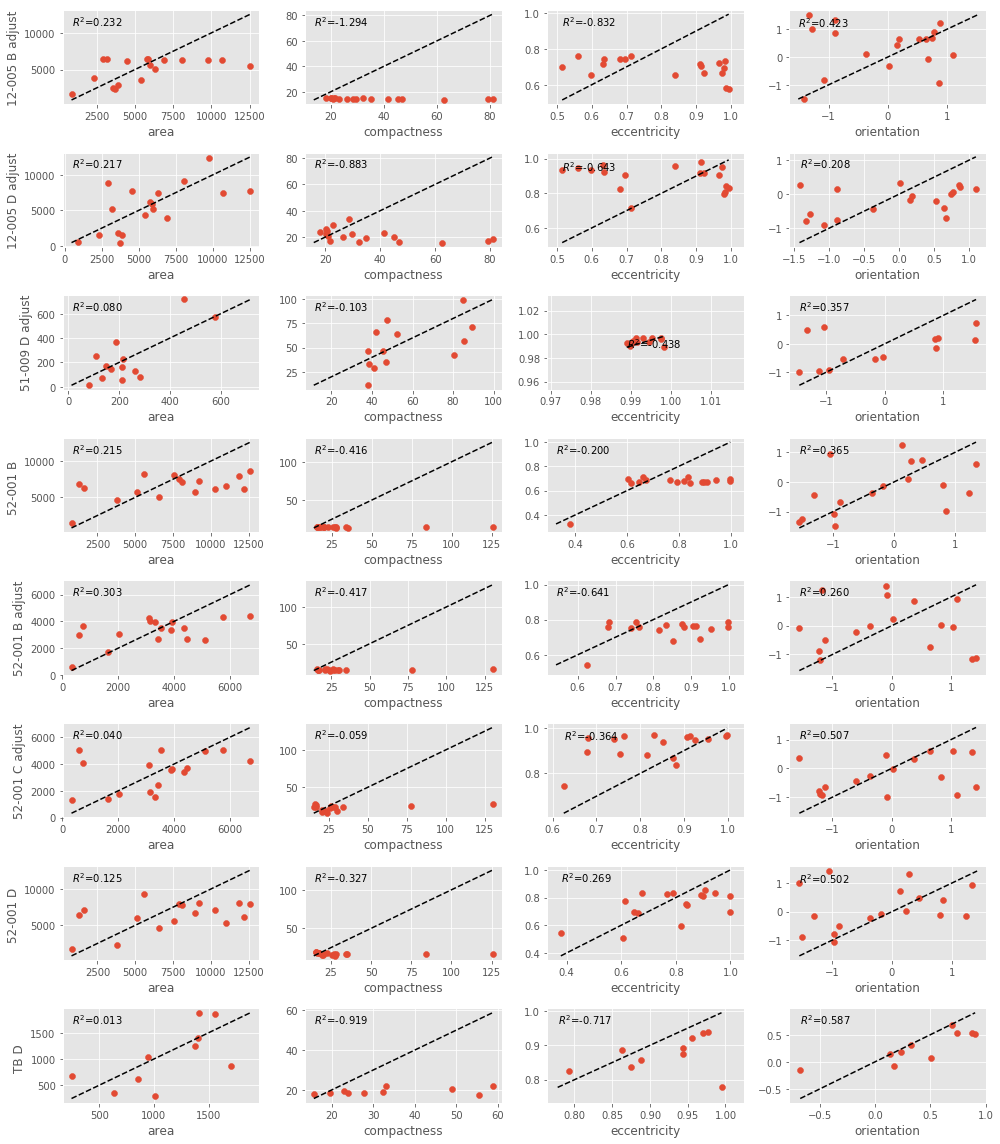

In [14]:
fig, axes = plt.subplots(ncols=len(columns), nrows=len(plot_files), figsize=(14, 2 * len(plot_files)))
for (_, row), axrow in zip(plot_files.iterrows(), axes):
    y, y_pred, _, _ = pickle.load(open(os.path.join(*row[['filepath', 'filename']]), 'rb'))
    if isinstance(y, list):
        y = pd.concat(y)
        y_pred = pd.concat(y_pred)
    for col, ax in zip(columns, axrow):
        ax.scatter(y[col], y_pred[col])
        minval = np.minimum(y[col].min(), y_pred[col].min())
        maxval = np.maximum(y[col].max(), y_pred[col].max())
        ax.plot([minval, maxval], [minval, maxval], 'k--')
        ax.set_xlabel(col)
        ax.text(minval, maxval, "$R^2$=%.3f" % float(row['r2_' + col]), va='top')
    axrow[0].set_ylabel('%s %s %s' % (row['subject'], row['model'],
                                      "adjust" if row['adjust_bias'] else ""))
fig.tight_layout()

In [15]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [16]:
y, y_pred, _, _ = pickle.load(open(os.path.join(*row[['filepath', 'filename']]), 'rb'))

In [17]:
for col in columns:
    df = pd.DataFrame({'y': y[col], 'y_hat': y_pred[col]})
    model = ols('y ~ y_hat', data=df).fit()
    anovaResults = anova_lm(model)
    print('')
    print(col)
    print(anovaResults)


area
           df        sum_sq        mean_sq         F    PR(>F)
y_hat     1.0  7.775158e+05  777515.815889  5.701605  0.044006
Residual  8.0  1.090943e+06  136367.885514       NaN       NaN

compactness
           df       sum_sq     mean_sq         F    PR(>F)
y_hat     1.0   384.895105  384.895105  1.795591  0.217058
Residual  8.0  1714.845287  214.355661       NaN       NaN

eccentricity
           df    sum_sq   mean_sq         F    PR(>F)
y_hat     1.0  0.003737  0.003737  0.918479  0.365938
Residual  8.0  0.032550  0.004069       NaN       NaN

orientation
           df    sum_sq   mean_sq         F    PR(>F)
y_hat     1.0  1.426838  1.426838  19.43405  0.002261
Residual  8.0  0.587356  0.073419       NaN       NaN


/home/mbeyeler/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
